In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

Using labelled data, this notebook will apply the KMeans clustering algorithm and evaluate the clusters using the specified performance metrics.

In [28]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from scipy.spatial import euclidean
from DBCV import DBCV

from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import hypertools as hyp
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [58]:
data = pd.read_csv("../Data/100dim_labeled_synth_data.csv").drop(["Unnamed: 0"], axis=1)

<IPython.core.display.Javascript object>

In [4]:
data["labels"] = data["labels"] - 1

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Frequency'>

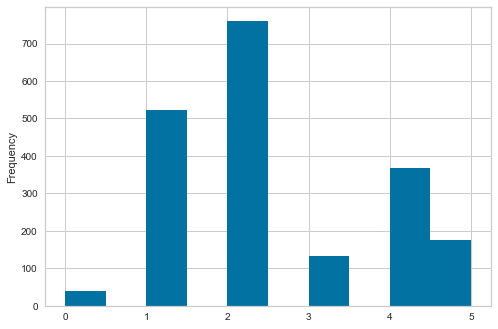

<IPython.core.display.Javascript object>

In [45]:
data["labels"].plot(kind="hist")

In [6]:
X = data.iloc[:, :-1]

<IPython.core.display.Javascript object>

In [7]:
# Fit K-Means
model = KMeans(n_clusters=6, random_state=0)
# Use fit_predict to cluster the dataset
predictions = model.fit_predict(X)

<IPython.core.display.Javascript object>

In [8]:
pd.Series(predictions).unique()

array([4, 1, 2, 3, 5, 0], dtype=int32)

<IPython.core.display.Javascript object>

In [9]:
X["cluster_labels"] = list(predictions)
labels = X.pop("cluster_labels")

<IPython.core.display.Javascript object>

# Visualization
yellowbrick <br>
hypertools <br>

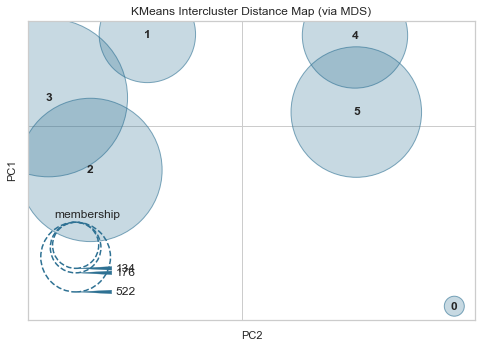

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

<IPython.core.display.Javascript object>

In [10]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(model)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

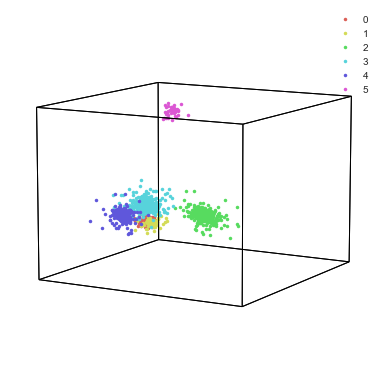

<IPython.core.display.Javascript object>

In [11]:
hyp.plot(X, ".", group=labels, legend=list(set(labels)))

# Evaluation Metrics

# https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
Gap Statistic <br>
Elbow Method <br>
Silhouette Coefficient <br>
Calinski-Harabasz Index <br>
Davies-Bouldin Index <br>

# https://towardsdatascience.com/evaluation-metrics-for-clustering-models-5dde821dd6cd
Purity <br>
Normalized mutual information (NMI) <br>
Rand index <br>
Adjusted Rand Index <br>
Jaccard Index <br>
Fowlkes Mallows Index <br>

# Gap Statistic*

## calculating the gap statistic for a single k

In [12]:
km = KMeans(5)

randomReference = np.random.random_sample(size=X.shape)  # generate reference dataset

km.fit(randomReference)  # fit to reference data
refDisp = km.inertia_  # get reference dispersion

km.fit(data)  # fit to original data
origDisp = km.inertia_  # get original dispersion

gap = np.log(refDisp) - np.log(origDisp)  # calculate gap

<IPython.core.display.Javascript object>

In [13]:
gap  # 6 clusters

0.2939737353705336

<IPython.core.display.Javascript object>

In [14]:
gap  # 5 clusters

0.2939737353705336

<IPython.core.display.Javascript object>

## calculating the gap statistic for many values of k

In [15]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({"clusterCount": [], "gap": []})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        resultsdf = resultsdf.append({"clusterCount": k, "gap": gap}, ignore_index=True)
        return (gaps.argmax() + 1, resultsdf)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Gap Statistic vs. K')

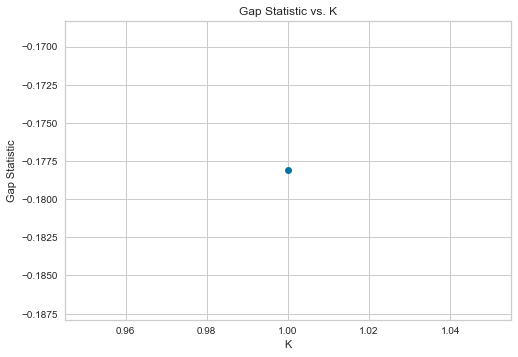

<IPython.core.display.Javascript object>

In [16]:
score_g, df = optimalK(X, nrefs=2, maxClusters=10)
plt.plot(df["clusterCount"], df["gap"], linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic vs. K")

To obtain an ideal clustering, you should select 𝑘 such that you maximize the gap statistic, i.e. 6 clusters is preferable to 5.

# Elbow Method*

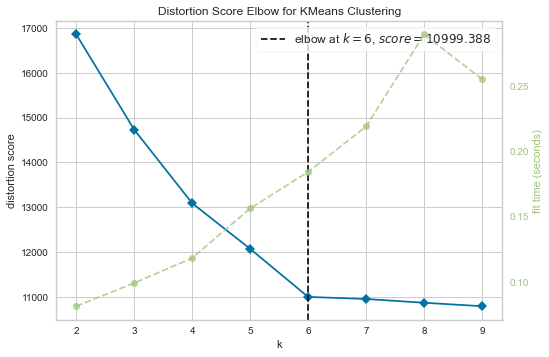

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

<IPython.core.display.Javascript object>

In [17]:
# Elbow Method for K means
# Import ElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True)
visualizer.fit(X)  # Fit data to visualizer
visualizer.show()  # Finalize and render figure

# Silhouette Coefficient*

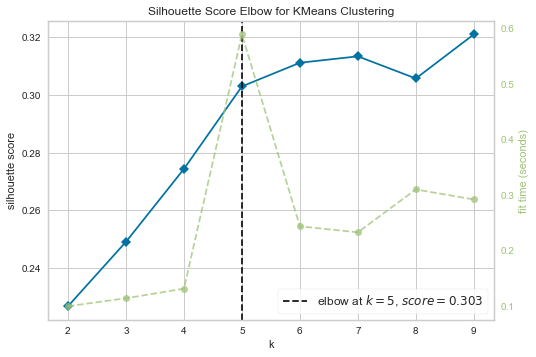

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

<IPython.core.display.Javascript object>

In [18]:
# Silhouette Score for K means
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2, 10), metric="silhouette", timings=True)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

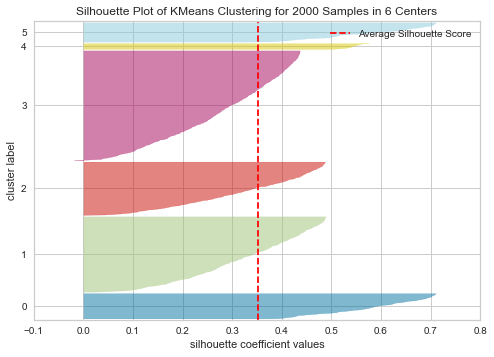

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [19]:
# Instantiate the clustering model with num_clusters = 6
model = KMeans(6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")

visualizer.fit(data)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [56]:
metrics.silhouette_score(X, predictions, metric="euclidean")

0.31119141971400033

<IPython.core.display.Javascript object>

# Calinski-Harabasz Index*

## maunal implementation

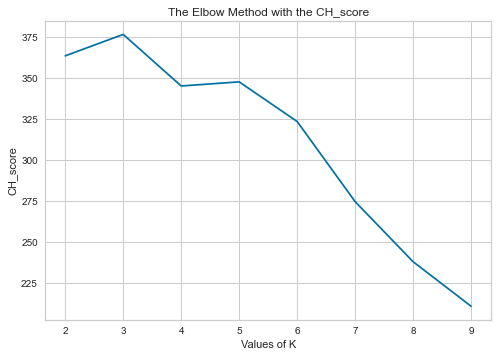

<IPython.core.display.Javascript object>

In [20]:
CH_score = []
K = range(2, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    # we store the cluster labels
    labels = kmeanModel.labels_

    CH_score.append(metrics.calinski_harabasz_score(X, labels))

plt.plot(K, CH_score, "bx-")
plt.xlabel("Values of K")
plt.ylabel("CH_score")
plt.title("The Elbow Method with the CH_score")
plt.show()

## yellowbrick implementation

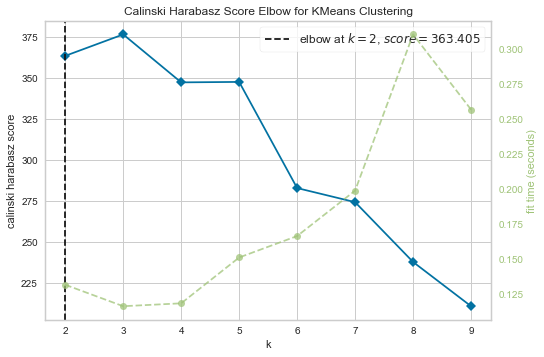

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

<IPython.core.display.Javascript object>

In [21]:
# Calinski Harabasz Score for K means
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric="calinski_harabasz", timings=True
)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

A solution yielding a peak on the calinski_harabasz line plot is ideal. It's therefore clear that this method indicates num_clusters = 3 would be ideal for this dataset.

# Davies-Bouldin Index*

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

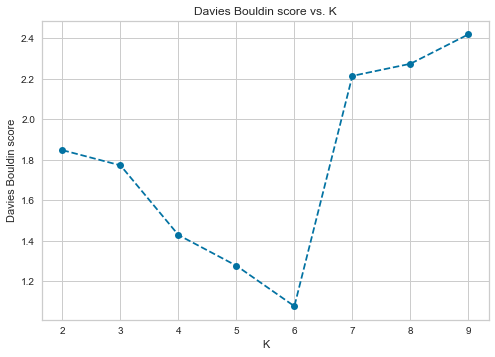

<IPython.core.display.Javascript object>

In [22]:
# Davies Bouldin score for K means
def get_kmeans_score(data, center):
    """
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    """
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(X)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(X, model)

    return score


scores = []
centers = list(range(2, 10))
for center in centers:
    scores.append(get_kmeans_score(X, center))

plt.plot(centers, scores, linestyle="--", marker="o", color="b")
plt.xlabel("K")
plt.ylabel("Davies Bouldin score")
plt.title("Davies Bouldin score vs. K")

Here, the Davies Bouldin score is minimized at 6 clusters and therefore correctly predicts that 6 clusters can be generated from the dataset using the kmeans algorithm.

# Purity*
https://towardsdatascience.com/evaluation-metrics-for-clustering-models-5dde821dd6cd
This metric is calculated by assigning a label to each cluster based on the most frequent class in it. The purity is then the number of correctly matches class and cluster labels, divided by the total number of data points.

In [23]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


purity_score(data["labels"], predictions)


0.9995

<IPython.core.display.Javascript object>

# Normalized Mutual Information (NMI)
Leverages the concept of entropy, to calculate the probability of a class label. This is calculated by dividing the number of data points belonging to that class by the total number of data points. 
 - When labels are more equally distributed, entropy is higher.
 - When labels are uneuqally distributed, entropy is lower as we are more certain of predicting the class with a greater share of the total. It's therefore clear that entropy decreases as uncertainty decreases.
<br>
NMI gives the reduction in entropy of class labels, when we are given cluster labels. Because NMI is normalized, it can be used to compare different clustering models that have different numbers of clusters.

In [24]:
metrics.normalized_mutual_info_score(data["labels"], predictions)

0.9977044845386489

<IPython.core.display.Javascript object>

# Rand Index
The measure of the similarity between two clusterings that compare actual class labels with predicted class labels. The index is calculated by summing:
 - The number of times a pair of elements are in the same cluster for both actual and predicted clustering.
 - The number of times a pair of elements are not in the same cluster for both actual and predicted clustering.
 
This number is then divided by the binomial coefficient of the total number of observations (n). So if n=15, we could calculate the binomial coefficient as 15+14+13+...+1.

# Adjusted Rand Index
A variation on the Rand Index that attempts to express what proportion of cluster assignments are correct by computing a similarity measure between two different clusterings. The measure counts pairs assigned to the same predicted cluster as the true cluster or to a different predicted cluster than the true cluster, adjusting for random chance.
<br>
The index ranges from -1 to 1, with -1 being the worst and 1 being the best.

In [27]:
metrics.adjusted_rand_score(data["labels"], predictions)

0.9987814759735945

<IPython.core.display.Javascript object>

# Jaccard Index

In [44]:
# define Jaccard Similarity function
def jaccard(true, pred):
    intersection = len(list(set(true).intersection(pred)))
    union = (len(true) + len(pred)) - intersection
    return float(intersection) / union


# find Jaccard Similarity between the two sets
jaccard(data["labels"], predictions)

0.0015022533800701052

<IPython.core.display.Javascript object>

In [48]:
metrics.jaccard_score(
    data["labels"], predictions, average="micro"
)  # accounts for class imbalance

0.010101010101010102

<IPython.core.display.Javascript object>

This is good as it indicates the clusters are not similar. The higher the percentage, the more similar the clusters.

# Fowlkes Mallows Index

In [30]:
metrics.fowlkes_mallows_score(data["labels"], predictions)

0.9990967331535417

<IPython.core.display.Javascript object>

# DBCV

In [57]:
DBCV(X, data["labels"], dist_function=euclidean)

NameError: name 'DBCV' is not defined

<IPython.core.display.Javascript object>

A complete list of internal and external clustering indices. https://cran.r-project.org/web/packages/clusterCrit/vignettes/clusterCrit.pdf